# Fitting Methods

This notebook presents fitting methods using Python and third-party Scientific Libraries such as Numpy, Scipy and StatsModels.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
mpl.rcParams['figure.figsize'] = 1.45*np.array(mpl.rcParams['figure.figsize'])

## Synthetic Data

Lets first prepare some synthetic data:

In [4]:
N = 100
x = np.linspace(-2, 8, N)
np.random.seed(0)

We will use a simple exponential with an offset as fitting function:

$$f(x) = \beta_0 \cdot \exp (\beta_1\cdot x) + \beta_2$$

In [5]:
def f(x, b0=2, b1=-0.45, b2=1.45):
    return b0*np.exp(b1*x)+b2

We also create the Jacobian:

$$\frac{\partial f}{\partial \beta_0} = \exp (\beta_1\cdot x),\quad
\frac{\partial f}{\partial \beta_1} = \beta_0\cdot x\cdot\exp (\beta_1\cdot x),\quad
\frac{\partial f}{\partial \beta_2} = 1$$

In [6]:
def df(x, b0=2, b1=-0.45, b2=1.45):
    return np.column_stack((np.exp(b1*x), b0*x*np.exp(b1*x), np.full(x.shape, 1, dtype=float)))

We add normal noise:

In [7]:
yth = f(x)
eps = 0.1*np.random.normal(size=x.size)
yexp = yth + eps

Bellow synthetic data (theoric and experimental) are shown:

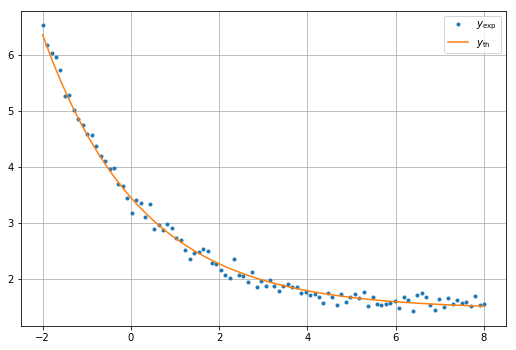

In [8]:
fig, axe = plt.subplots()
axe.plot(x, yexp, '.', label='$y_\mathrm{exp}$')
axe.plot(x, yth, '-', label='$y_\mathrm{th}$')
axe.legend()
axe.grid()

## Fitting

### scipy.optimize

We will first introduce [`scipy.optimize`][1] method which uses by default a [Levenberg-Marquard][2] algorithm. This aproach is handy when dealing with [Non Linear Least Squares][3] problems. 


[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
[2]: https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm
[3]: https://en.wikipedia.org/wiki/Non-linear_least_squares

In [9]:
from scipy.optimize import curve_fit

A naive call to `curve_fit` does not work:

In [10]:
try:
    beta, bcov = curve_fit(f, x, yexp)
except Exception as err:
    print(err)

Optimal parameters not found: Number of calls to function has reached maxfev = 800.


Increasing `maxfev` (`leastsq` parameters passed by `kwargs`) does not help at all, the algorithm does not converge in the right direction:

In [11]:
beta, bcov = curve_fit(f, x, yexp, maxfev=1000)
beta

array([ -2.00832967e+04,   1.89814113e-05,   2.00869917e+04])

If we help the solver providing a initial guess for the parameters, it can solve it:

In [12]:
beta, bcov = curve_fit(f, x, yexp, p0=[1,-1,1])
beta

array([ 1.97758106, -0.46857595,  1.46883607])

We can also provides bounds for parameters:

In [13]:
beta, bcov = curve_fit(f, x, yexp, bounds=([0., -2., 0.], [3., 2., 2.]))
beta

array([ 1.97758124, -0.46857589,  1.46883597])

Providing the Jacobian is not enough to help:

In [14]:
try:
    beta, bcov = curve_fit(f, x, yexp, jac=df)
except Exception as err:
     print(err)

Optimal parameters not found: Number of calls to function has reached maxfev = 400.


But it could help to converge quickly:

In [15]:
beta, bcov = curve_fit(f, x, yexp, jac=df, p0=[1,-1,1])
beta

array([ 1.97758107, -0.46857594,  1.46883607])

To get the standard error on parameters, simply use covariance matrix:

In [16]:
sbeta = np.sqrt(np.diag(bcov))
sbeta

array([ 0.032081  ,  0.00856638,  0.02000121])

Then we can reconstruct our estimation function $\hat{y}$:

In [17]:
yhat = f(x, *beta)

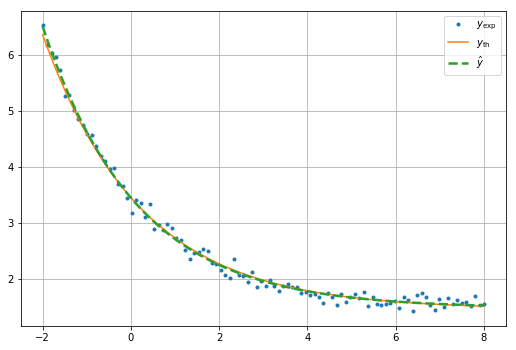

In [18]:
fig, axe = plt.subplots()
axe.plot(x, yexp, '.', label='$y_\mathrm{exp}$')
axe.plot(x, yth, '-', label='$y_\mathrm{th}$')
axe.plot(x, yhat, '--', linewidth=2.5, label='$\hat{y}$')
axe.legend()
axe.grid()

And computes absolute and relative errors before theoritical function:

In [19]:
err = (yhat-yth)
perr = err/yth

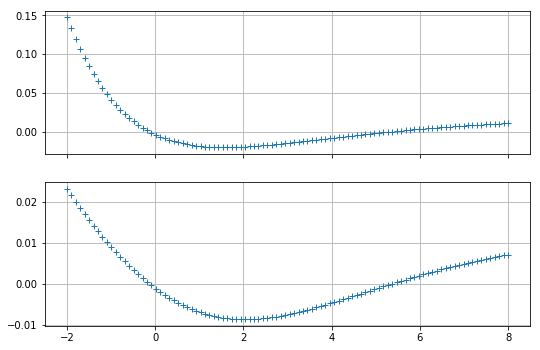

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(x, err, '+', label='$y_\mathrm{exp}$')
axes[0].grid()
axes[1].plot(x, perr, '+', label='$y_\mathrm{exp}$')
axes[1].grid()

### np.leastsq